# IMPORTANT NOTE

This version of the code is for me (Nicholas) to meddle with, testing fixes and generating data reports for good targets. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy as ap
from scipy.stats import binned_statistic_dd
from scipy.stats import linregress

# Atmospheric Prioritization

The goal of this code is to find planets which are good candidates for atmospheric follow-up. We are particularly interested in planets which are from poorly-covered regions of parameter space (e.g., smaller than previously-known planets, or around different types of star, or with more/less irradiation). Because the code was developed for TESS planets, we impose a cutoff at 11.2 R_e. If you change that, beware of the breakdown of the empirical mass-radius relationship for larger planets; you will need to implement a statistical model, e.g. mr_forecaster by Chen & Kipping 2017. 

In [3]:
from priority_tools import *

# Loading the Necessary Data

The first thing to do is get all the data set up. You need to load in the toi+ list (data/toi/toi+-...), where ... is the date of the most recent data release. If you are curious about previous releases, some of them are also in that directory. You also need the TIC star info, which has V, J, and K magnitudes that are missing from TOI+. 

In [5]:
#generate the key names for all the TOI+ columns we need
rp_key,ms_key,pp_key,Ts_key,ars_key,Jmag_key,\
    Vmag_key,rs_key,dec_key,Fp_key,mp_key,\
    mp_units,id_key = tess_colnames()

#load the TOI+ list
toiplus = pd.read_csv('data/toi/toi+-2020-01-15.csv',
                      delimiter=',',header=4)

#load the TIC star info
TIC_info = pd.read_csv('data/exofop/TIC_star_info_jan_15_all.csv',
                       delimiter=',',header=10)

#run the data cleaning function 
tess = clean_tess_data(toiplus, TIC_info, include_qlp=False)

#load the known planets (and Kepler PCs) table, and merge it
kps = pd.read_csv(r'data/kp-k14_pc-v14.csv')
d = tess.append(kps[np.logical_and(kps['K_amp'] > 1.5, 
                                   kps['TSM'] > 10)],sort=False) 
    #the K_amp cut wasn't made in the data itself, but is 
    #necessary to cut some of those not-real long-period
    #KOIs as well as known planets for which we can't get masses
    
    #The TSM cut is also made to exclude dubious Kepler planets 
    #(i.e., way too low Rp/Rs on a dim star for atmospheres) but 
    

# Binning

With all the data loaded, we can run the binning function and generate the pandas dataframe object that we can use for the rest of the analysis. 

In [6]:
#defining the bins: log-uniform in radius and Fp, 
#uniform in Teff. Right now, you need 6 bin edges
#for radius and Fp and 4 for Teff; we can change
#that by editing the "labels" in binning_function
rad_bins = 10**(np.linspace(0,1.05,6)) 
fpl_bins = 10**(np.linspace(-1,4,6))
tef_bins = np.array([2500,3900,5200,6500])
bins = [rad_bins, fpl_bins, tef_bins]

b = binning_function(d, bins) #b stands for "binned", 
                            #to make use easier

# Playing With The Data

Now, we can start looking at the data! Two very simple things we might want to do are look at a single TOI, and look at it in the context of its bin. If you've used pandas before, messing around with these data will be straightforward; if not, here are some useful tricks. To load a single object, use: b[b[id_key] == x], where x is the ID number including .01 or .02 (or .03, or whichever planet you want if it's a highly multiple system)

In [7]:
#make sure we can see the columns in the middle of the output
pd.options.display.max_columns = 100 

#call the request
b[b[id_key] == 256.02]

#the output tells us the radius, insolation, and Teff bins, as
#well as all the data from the TOI plus list and values that
#we've calculated

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Edited,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2,1,spoc,92226327.0,256.02,11.247108,-15.271294,11.238,0.07,1389.293276,0.002136,3.778378,0.000784,1.028338,0.2879,3334.77603,300.73108,3,LHS-1140c,5.05701,0.0,2.0,0.19,0.0,1.136554,0.410558,379.011837,3131.0,0.0,4.876768,10.993546,False,2018-11-30 22:06:23+0000,2019-12-17 15:43:34+0000,0.150019,1.536701,28.557982,2.238591,92226327.0,11.248632,-15.274109,14.15,9.612001,9.092,167.798372,NaN,1,2,1,2.0


In [8]:
#you can also ask for a few specific columns if you want 
#a much less messy output

b[b[id_key] == 1598.01][[rp_key,pp_key,Ts_key,Fp_key,'TSM','V mag','J mag','TSM','priority']]

,,,Planet Radius Value,Orbital Period Value,Effective Temperature Value,Effective Stellar Flux Value,TSM,V mag,J mag,TSM,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,
3,5,3,3.780692,1.103694,6011.0,8050.41244,103.360934,9.145001,8.1,103.360934,1.0


To look at an entire bin, use b.loc[x,y,z], where x, y, and z are the radius, insolation, and Teff bin, respetively. Note that these are 1-indexed, not 0-indexed (sorry). If it's priority values alone you're interested in, scroll all the way to the right. 

In [9]:
#look into this bin, and select only the top 5 (by TSM)
b.loc[3,3,3].head(10)

Source Pipeline          TIC Full TOI ID  \
radius_bin insol_bin st_Teff_bin                                            
3          3         3                      spoc  269701147.0     1339.01   
                     3                      spoc   33692729.0      469.01   
                     3                      spoc  453211454.0      509.01   
                     3                      spoc  377064495.0      561.01   
                     3                       NaN          NaN   HD 3167 c   
                     3                      spoc  269701147.0     1339.02   
                     3                      spoc  142276270.0     1136.03   
                     3                       NaN          NaN    K2-198 b   
                     3                      spoc  232540264.0     1247.01   
                     3                      spoc  224297258.0     1279.01   

                                  TIC Right Ascension  TIC Declination  \
radius_bin insol_bin st_Teff_bin                                         
3          3         3                     302.023979        66.850576   
                     3                      93.058225       -14.650035   
                     3                     117.924970         9.386054   
                     3                     148.185590         6.216373   
                     3                            NaN         4.381469   
                     3                     302.023979        66.850576   
                     3                     192.184889        64.855319   
                     3                            NaN        -6.464886   
                     3                     227.870476        71.840951   
                     3                     185.063883        56.201148   

                                  TMag Value  TMag Uncertainty  \
radius_bin insol_bin st_Teff_bin                                 
3          3         3               8.29300             0.006   
                     3               8.71900             0.019   
                     3               7.90500             0.018   
                     3               9.49500             0.017   
                     3                   NaN               NaN   
                     3               8.29300             0.006   
                     3               8.93600             0.006   
                     3                   NaN               NaN   
                     3               8.47240             0.006   
                     3               9.99454             0.006   

                                  Orbital Epoch Value  Orbital Epoch Error  \
radius_bin insol_bin st_Teff_bin                                             
3          3         3                    1715.354486             0.002530   
                     3                    1474.567411             0.001922   
                     3                    1494.445731             0.001498   
                     3                    1527.055259             0.006522   
                     3                            NaN                  NaN   
                     3                    1726.054253             0.001723   
                     3                    1699.385305             0.001956   
                     3                            NaN                  NaN   
                     3                    1687.651208             0.004126   
                     3                    1717.455093             0.002948   

                                  Orbital Period Value  Orbital Period Error  \
radius_bin insol_bin st_Teff_bin                                               
3          3         3                        8.880832              0.000820   
                     3                       13.632935              0.002640   
                     3                       18.119809              0.002151   
                     3                       10.781327              0.009318   
         

Let's try the visualization tool, which displays all the objects in a given radius bin. Dots scale linearly with planet radius. Labels indicate the object: floats are TOIs (i.e. "421.01" is TOI 421.01), anything starting with "K0" or "EPIC" is an unconfirmed KOI or K2 object, respectively, and everything else is a confirmed planet (including some previously-confirmed TOIs - for example TOI 270c falls into this category). Note that long-period KOIs (i.e., those in the top left - with relatively hot stars but earth-like insolation) are generally considered unreliable and should not automatically be assumed to actually exist or be good potential atmospheric targets. 

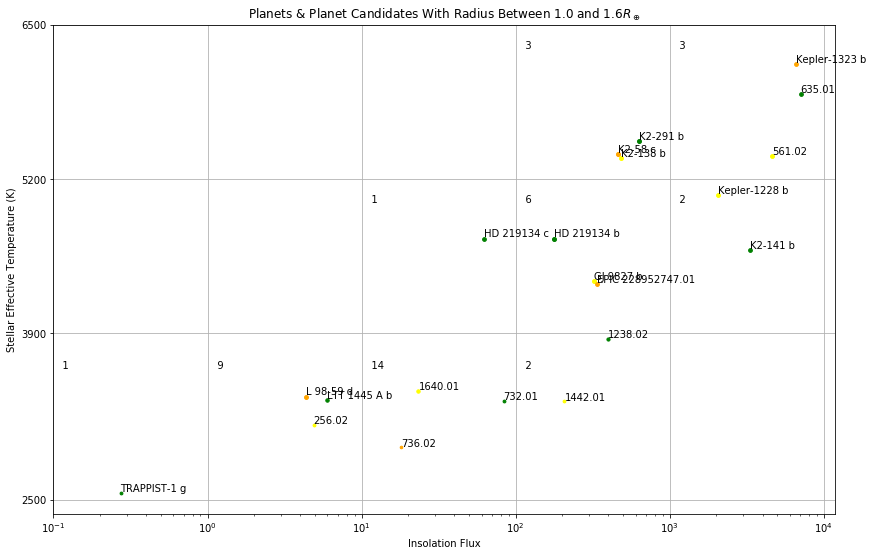

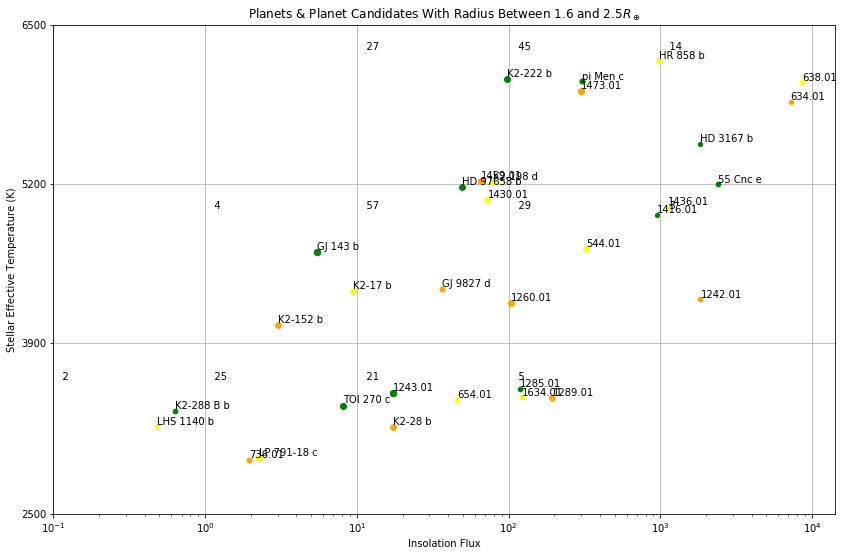

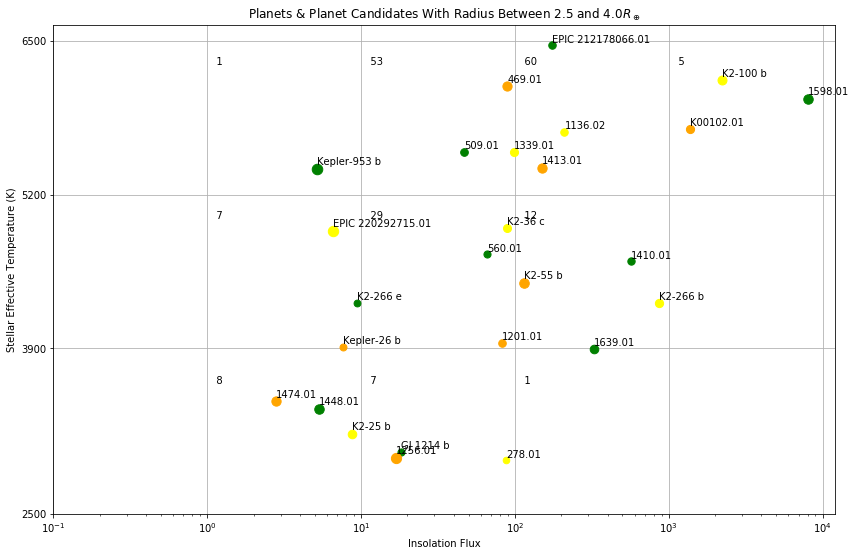

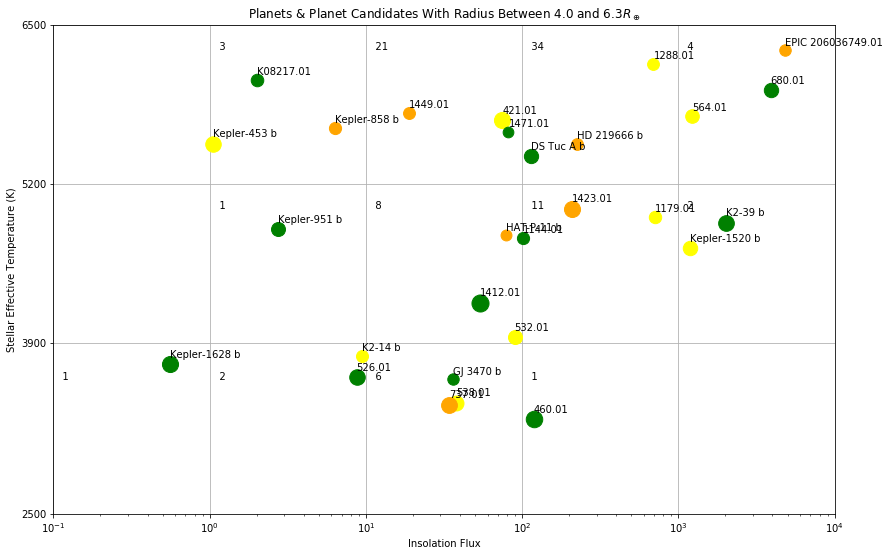

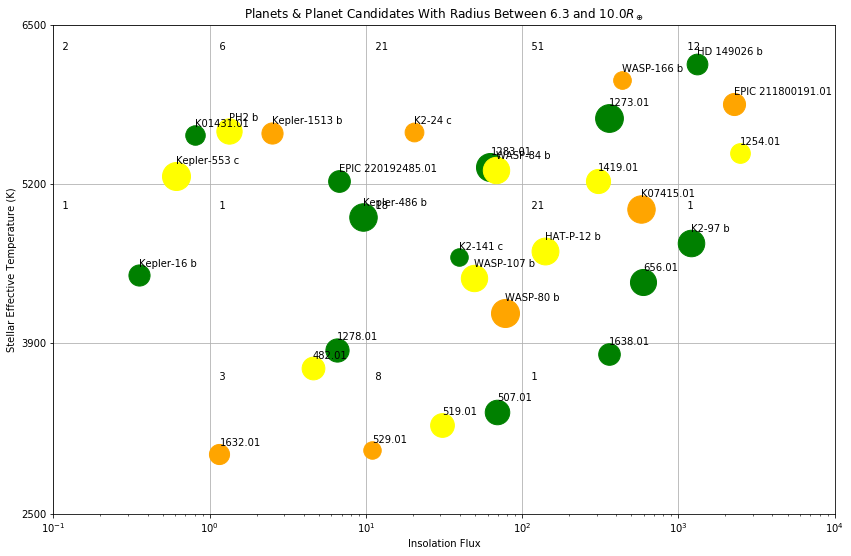

In [10]:
#bin_plotter inputs are the binned data, the bin edges
#(as defined above), and the radius bin of interest
for i in np.arange(1,6):
    bin_plotter(b,bins,i)

In [13]:
b.loc[1,2,1]

Source Pipeline         TIC   Full TOI ID  \
radius_bin insol_bin st_Teff_bin                                             
1          2         1                       NaN         NaN     L 98-59 d   
                     1                      spoc  92226327.0        256.02   
                     1                       NaN         NaN  LTT 1445 A b   
                     1                      spoc  98796344.0        455.01   
                     1                       NaN         NaN  TRAPPIST-1 b   
                     1                       NaN         NaN  Kepler-445 b   
                     1                       NaN         NaN    LHS 1140 c   
                     1                       NaN         NaN  Kepler-504 b   
                     1                       NaN         NaN  TRAPPIST-1 c   

                                  TIC Right Ascension  TIC Declination  \
radius_bin insol_bin st_Teff_bin                                         
1          2         1                            NaN       -68.313000   
                     1                      11.247108       -15.271294   
                     1                            NaN       -16.593372   
                     1                      45.464200       -16.593400   
                     1                            NaN        -5.041274   
                     1                            NaN        46.498552   
                     1                            NaN       -15.271532   
                     1                            NaN        45.972398   
                     1                            NaN        -5.041274   

                                  TMag Value  TMag Uncertainty  \
radius_bin insol_bin st_Teff_bin                                 
1          2         1                   NaN               NaN   
                     1                11.238             0.070   
                     1                   NaN               NaN   
                     1                 8.640             0.018   
                     1                   NaN               NaN   
                     1                   NaN               NaN   
                     1                   NaN               NaN   
                     1                   NaN               NaN   
                     1                   NaN               NaN   

                                  Orbital Epoch Value  Orbital Epoch Error  \
radius_bin insol_bin st_Teff_bin                                             
1          2         1                            NaN                  NaN   
                     1                    1389.293276             0.002136   
                     1                            NaN                  NaN   
                     1                    1412.708786             0.000910   
                     1                            NaN                  NaN   
                     1                            NaN                  NaN   
                     1                            NaN                  NaN   
                     1                            NaN                  NaN   
                     1                            NaN                  NaN   

                                  Orbital Period Value  Orbital Period Error  \
radius_bin insol_bin st_Teff_bin                                               
1          2         1                        7.450860                   NaN   
                     1                        3.778378              0.000784   
                     1                        5.358820                   NaN   
                     1                        5.358807              0.000351   
                     1                        1.510871                   NaN   
                     1                        2.984151                   NaN   
                     1                        3.777931                   NaN   
                     1                        9.54927

In [14]:
#all priorities
p1 = b[b['priority']==1].reset_index(drop=True)[id_key].values
p1tois = []
for obj in p1:
    if type(obj) == float:
        p1tois.append(obj)
p1tois.sort()
p1tois

[460.01,
 507.01,
 509.01,
 526.01,
 560.01,
 635.01,
 656.01,
 680.01,
 732.01,
 1144.01,
 1238.02,
 1243.01,
 1273.01,
 1278.01,
 1283.01,
 1285.01,
 1410.01,
 1412.01,
 1416.01,
 1448.01,
 1471.01,
 1598.01,
 1638.01,
 1639.01]

In [15]:
#all priorities
p2 = b[b['priority']==2].reset_index(drop=True)[id_key].values
p2tois = []
for obj in p2:
    if type(obj) == float:
        p2tois.append(obj)
p2tois.sort()
p2tois

[256.02,
 278.01,
 421.01,
 482.01,
 519.01,
 532.01,
 538.01,
 544.01,
 561.02,
 564.01,
 638.01,
 654.01,
 1136.02,
 1179.01,
 1254.01,
 1288.01,
 1339.01,
 1419.01,
 1430.01,
 1436.01,
 1442.01,
 1634.01,
 1640.01]

In [16]:
p3 = b[b['priority']==3].reset_index(drop=True)[id_key].values
p3tois = []
for obj in p3:
    if type(obj) == float:
        p3tois.append(obj)
p3tois.sort()
p3tois

[469.01,
 529.01,
 634.01,
 736.01,
 736.02,
 737.01,
 1201.01,
 1242.01,
 1256.01,
 1260.01,
 1289.01,
 1413.01,
 1423.01,
 1449.01,
 1459.01,
 1473.01,
 1474.01,
 1632.01]

In [20]:
for r in np.arange(1,6,1):
    for f in np.arange(1,6,1):
        for t in np.arange(1,4,1):
            try:
                x = b.loc[r,f,t].dropna(axis=0,subset=['TSM'])
            except KeyError:
                continue
            med = np.median(x['TSM'])
            if med == 0:
                med = np.mean(x['TSM'])
            x['Value'] = (x['TSM'] / med) - (x['V mag']/3)
            print(med)
            print(x[x['Value']>0][[id_key,'Value']])
'''
ok, so,this works ok, but we need more:
    -how to relatively deprioritize something if a bunch of other ones
        are equally valuable. That is, even if it's above the median, 
        as long as we have ONE that we get a good mass one, we're not
        as interested (e.g. the 333 bin, which is quite populous)
    -make sure we cut above V 12 or 13; generally ensure that 
        the ones we're picking are actually observable 
'''           


43.26958509470039
Empty DataFrame
Columns: [Full TOI ID, Value]
Index: []
30.69911698397491
                                 Full TOI ID    Value
radius_bin insol_bin st_Teff_bin                     
1          3         1                732.01  0.91745
104.29026628230785
                                  Full TOI ID     Value
radius_bin insol_bin st_Teff_bin                       
1          3         2            HD 219134 c  0.111098
34.79624272243419
Empty DataFrame
Columns: [Full TOI ID, Value]
Index: []
13.627208890248104
                                  Full TOI ID      Value
radius_bin insol_bin st_Teff_bin                        
1          4         2            HD 219134 b  19.572376
                     2              GJ 9827 b   2.714111
19.944898227641772
Empty DataFrame
Columns: [Full TOI ID, Value]
Index: []
59.485544934330655
Empty DataFrame
Columns: [Full TOI ID, Value]
Index: []
2.690190756129454
                                 Full TOI ID      Value
radius_bin ins

In [33]:
b.loc[2,5,3].dropna(subset=['TSM'])

Source Pipeline          TIC  \
radius_bin insol_bin st_Teff_bin                                
2          5         3                       NaN          NaN   
                     3                      spoc   78154865.0   
                     3                      spoc  344926234.0   
                     3                       NaN          NaN   
                     3                      spoc  229747848.0   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   

                                       Full TOI ID  TIC Right Ascension  \
radius_bin insol_bin st_Teff_bin                                          
2          5         3                   HD 3167 b                  NaN   
                     3                      638.01           147.867332   
                     3                      634.01           151.557480   
                     3                    K2-131 b                  NaN   
                     3                     1347.01           280.326761   
                     3                   CoRoT-7 b                  NaN   
                     3                    K2-183 b                  NaN   
                     3            EPIC 220674823 b                  NaN   
                     3                 Kepler-21 b                  NaN   
                     3                   WASP-47 e                  NaN   
                     3                     K2-61 b                  NaN   
                     3                    K2-230 b                  NaN   
                     3                   K04022.01                  NaN   

                                  TIC Declination  TMag Value  \
radius_bin insol_bin st_Teff_bin                                
2          5         3                   4.381469         NaN   
                     3                  -4.123348       8.909   
                     3                   3.946547       9.102   
                     3                  -9.765218         NaN   
                     3                  70.289941      10.716   
                     3                  -1.063033         NaN   
                     3                  14.019461         NaN   
                     3                  10.794699         NaN   
                     3                  38.714016         NaN   
                     3                 -12.018885         NaN   
                     3                 -13.560024         NaN   
                     3                  -6.576109         NaN   
                     3                  43.456860         NaN   

                                  TMag Uncertainty  Orbital Epoch Value  \
radius_bin insol_bin st_Teff_bin                                          
2          5         3                         NaN                  NaN   
                     3                       0.019          1517.427930   
                     3                       0.019          1517.428167   
                     3                         NaN                  NaN   
                     3                       0.007          1684.402610   
                     3                         NaN                  NaN   
                     3                         NaN                  NaN   
                     3                         NaN                  NaN   
                     3                         NaN                  NaN   
                     3                         NaN                  NaN   
                     3                         NaN     

In [30]:
b[b[id_key] == 1283.01][[rp_key,pp_key,Ts_key,Fp_key,'TSM','V mag','J mag','TSM','priority']]

,,,Planet Radius Value,Orbital Period Value,Effective Temperature Value,Effective Stellar Flux Value,TSM,V mag,J mag,TSM,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,
5,3,3,11.206356,10.337891,5336.96,62.594515,324.831243,10.375,9.017,324.831243,1.0


In [37]:
b[b[id_key] == 732.01]#[[rp_key,pp_key,Ts_key,Fp_key,'TSM','V mag','J mag','TSM','priority']]

,,,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Edited,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,TSM,Unnamed: 0,radius_bin,insol_bin,st_Teff_bin,priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,1,spoc,36724087.0,732.01,154.6464,-11.7167,10.534,0.058,1543.91148,0.001189,0.768418,0.000067,0.816472,0.266768,1252.849899,105.63316,9,NaN,4.94957,0.423263,1.0,0.3,0.054,1.134371,0.573323,770.585234,3329.0,72.0,83.330451,11.443317,False,2019-06-06 16:40:58+0000,2019-12-17 15:43:37+0000,0.292039,1.52616,7.810036,2.424886,36724087.0,154.644903,-11.717801,13.14,9.007,8.439,162.627035,NaN,1,3,1,1.0


In [33]:
b.loc[5,4,2]

Source Pipeline          TIC  \
radius_bin insol_bin st_Teff_bin                                
5          4         2                      spoc   36734222.0   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                      spoc  416195870.0   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   
                     2                       NaN          NaN   

                                        Full TOI ID  TIC Right Ascension  \
radius_bin insol_bin st_Teff_bin                                           
5          4         2                       656.01           154.908361   
                     2                   HAT-P-12 b                  NaN   
                     2                    K07415.01                  NaN   
                     2                   HAT-P-26 b                  NaN   
                     2                      1264.01           287.241995   
                     2            EPIC 210365511.01                  NaN   
                     2                    HAT-P-3 b                  NaN   
                     2                  HD 221416 b                  NaN   
                     2                    WASP-43 b                  NaN   
                     2                 Kepler-425 b                  NaN   
                     2                     K2-127 b                  NaN   
                     2                    WASP-45 b                  NaN   
                     2                    HATS-69 b                  NaN   
                     2            EPIC 212586030.01                  NaN   
                     2                   HAT-P-20 b                  NaN   
                     2                    K07389.01                  NaN   

                                  TIC Declination  TMag Value  \
radius_bin insol_bin st_Teff_bin                                
5          4         2                  -9.806286      11.016   
                     2                  43.493534         NaN   
                     2                  48.846512         NaN   
                     2                   4.059997         NaN   
                     2                  57.344183      10.634   
                     2                  12.633847         NaN   
                     2                  48.028667         NaN   
                     2                 -21.801424         NaN   
                     2                  -9.806276         NaN   
                     2                  40.567738         NaN   
                     2                 -11.588979         NaN   
                     2                 -35.998260         NaN   
                     2                 -60.891683         NaN   
                     2                 -10.896922         NaN   
                     2                  24.336630         NaN   
                     2                  48.323318         NaN   

                                  TMag Uncertainty  Orbital Epoch Value  \
radius_bin insol_bin st_Teff_bin                                          
5          4         2                      0.0180          1543.603636   
                     2                         NaN                  NaN   
                     2